# <font color=blue><b>GeoPandas - mapping with Python</b></font>
Works on top of Pandas, and with MatplotLib

In [41]:
import pandas as pd
import geopandas as gpd
#import matplotlib.pylpot as plt
from matplotlib import pyplot as plt

#seems to make no difference
%matplotlib inline 

#from mpl_toolkits.axes_grid1 import make_axes_locatable

uganda = gpd.read_file('D:/Temp/GeoPandas/Uganda_districts2010.shp') #currently latlon (unprojected), needs to be projected to UTM

#uganda.crs # <Geographic 2D CRS: EPSG:4326> (unprojected). We have to project it

#deprecated
#uganda = uganda.to_crs({'init': 'epsg:32636'}) #Uganda is UTM 36N, epsg code is 32636 - search online

#Use this
uganda = uganda.to_crs(epsg=32636)

#uganda.crs # <Projected CRS: EPSG:32636>

## How to get the EPSG code for a given UTM - works like a charm
#from pyproj import CRS
#crs = CRS.from_dict({'proj': 'utm', 'zone': 36, 'north': True})
#print(crs.to_authority())  # ('EPSG', '32636')

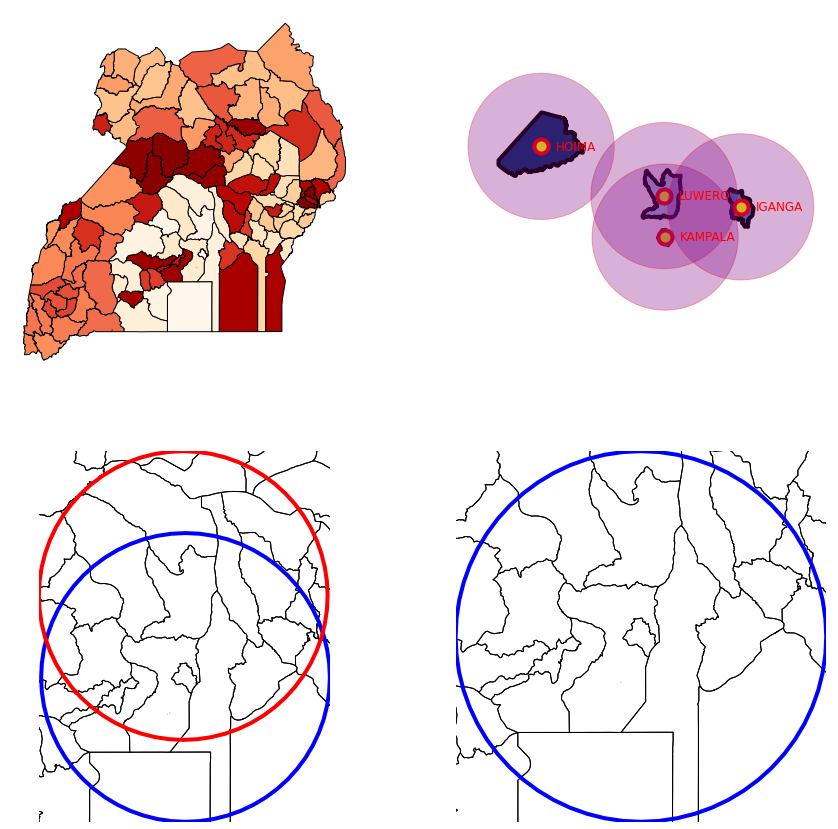

In [42]:
#fig, ax1 = plt.subplots(1, figsize=(15, 15))
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20), constrained_layout=True, subplot_kw=dict(aspect="equal"), gridspec_kw = {'width_ratios':[2, 2], 'height_ratios':[2, 2]})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=False)

"""
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()
"""

#might be tempted to use this list comprehension for the above. It works, but is it really good practice? 
#Note taht we are not creating a new list here but performing an action using a method
[i.set_axis_off() for i in [ax1, ax2, ax3, ax4]]

#uganda[uganda['hiv_rate'] >= 0].plot(ax=ax1
uganda.plot(ax=ax1
            , cmap='OrRd' #'YlOrBr' #'Set1' #'Dark2' #'prism' #'plasma' #'Pastel1'
            #, alpha=0.5
            #, facecolor='k'
            , edgecolor='black'
            #, column='hiv_rate'
            , legend=True                                     
            , legend_kwds={'label': "HIV Rate", 'orientation': 'horizontal'}
            #, missing_kwds={
            #    "color": "lightgrey",
            #    "edgecolor": "red",
            #    "hatch": "///",
            #    "label": "Missing values"
            #}
            , linewidth=1
            , zorder=0                                     
)
#uganda

#Filter and plot GeoDataframe of study areas: Kampala, Iganga, Hoima, Luwero
study_areas = uganda.loc[uganda['DNAME_2010'].str.upper().isin(['KAMPALA', 'IGANGA', 'HOIMA', 'LUWERO'])]
study_areas.to_crs(uganda.crs)
study_areas.apply(lambda x: ax2.annotate(s=x.DNAME_2010, xy=x.geometry.centroid.coords[0], ha='left', fontsize=12, color='red', horizontalalignment='right', verticalalignment='center', xytext=(15, 0), textcoords='offset pixels'), axis=1)
study_areas.plot(ax=ax2, cmap='Blues', edgecolor='black', linewidth=4)

#Get and plot centroids of study areas
study_areas_centroids = study_areas.centroid
study_areas_centroids.to_crs(uganda.crs)
study_areas_centroids.plot(ax=ax2, color='yellow', edgecolor='red', linewidth=4, markersize=200)

#Get buffer around centroids - 100 kms (100,000 meters)
#type(study_areas_centroids)

study_areas_buffers = study_areas_centroids.buffer(distance=100000)
#add attribte DNAME_2010
study_areas_buffers.plot(ax=ax2, color='purple', edgecolor='red', linewidth=1, alpha=0.3, aspect='auto')

#study_areas_buffers1 = study_areas_buffers.loc[uganda['DNAME_2010']=='KAMPALA']
#study_areas_buffers1 = study_areas_buffers.iloc[0]
#study_areas_buffers1.plot()
#study_areas_centroids

#use the geometry of study_areas_buffers to reconstruct individual buffers
study_areas_buffers_kampala = gpd.GeoDataFrame(study_areas.loc[study_areas['DNAME_2010']=='KAMPALA'], geometry = study_areas_buffers)
study_areas_buffers_luwero = gpd.GeoDataFrame(study_areas.loc[study_areas['DNAME_2010']=='LUWERO'], geometry = study_areas_buffers)

#plot the various layers for geoprocessing analysis
study_areas_buffers_kampala.plot(ax=ax3, color='none', edgecolor='blue', linewidth=4, zorder=0)
study_areas_buffers_luwero.plot(ax=ax3, color='none', edgecolor='red', linewidth=4, zorder=0)
uganda.plot(ax=ax3, color='none', edgecolor='black', linewidth=1, zorder=-1)

#Zoom in
#total_bounds teturns a tuple containing minx, miny, maxx, maxy
bounds1 = study_areas_buffers_kampala.geometry.total_bounds
bounds2 = study_areas_buffers_luwero.geometry.total_bounds

#ax3.set_xlim([bounds[0],  bounds[2]])
#ax3.set_ylim([bounds[1],  bounds[3]])

#to zoom to two layers, get the min of minx and miny; get the max of maxx, maxy
ax3.set_xlim([min(bounds1[0], bounds2[0]), max(bounds1[2], bounds2[2])])
ax3.set_ylim([min(bounds1[1], bounds2[1]), max(bounds1[3], bounds2[3])])

#subplot ax4
study_areas_buffers_kampala.plot(ax=ax4, color='none', edgecolor='blue', linewidth=4, zorder=0)
uganda.plot(ax=ax4, color='none', edgecolor='black', linewidth=1, zorder=-1)
#zoom
ax4.set_xlim(bounds1[0], bounds1[2])
ax4.set_ylim(bounds1[1], bounds1[3])

# Create an output path for the data
out = r"D:/Temp/GeoPandas/selection.shp"
# Select first 10 rows
selection = uganda.loc[0:10]
# Write those rows into a new Shapefile (the default output file format is Shapefile)
selection.to_file(out)

#save the map
plt.savefig('D:/Temp/GeoPandas/map1.png', dpi=200) 

#store a layer (DataFrame) to to_html - can then insert in an html page
uganda_html = uganda.to_html(index_names=False) #to html table


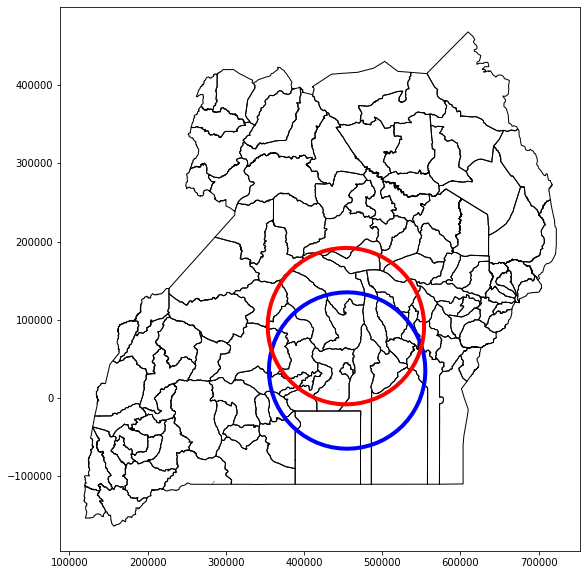

In [43]:
#Lets save study_areas_buffers_kampala and study_areas_buffers_luwero to nes shapefiles

study_areas_buffers_kampala.to_file('D:/Temp/GeoPandas/kampala_buffer.shp')
study_areas_buffers_luwero.to_file('D:/Temp/GeoPandas/luwero_buffer.shp')

#load them afresh to confirm
kampala_buffer = gpd.read_file('D:/Temp/GeoPandas/kampala_buffer.shp')
luwero_buffer = gpd.read_file('D:/Temp/GeoPandas/luwero_buffer.shp')
uganda_all = uganda.copy() #new copy

#test their crs #they are all projected <Projected CRS: EPSG:32636>

#plot them
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=False)
kampala_buffer.plot(ax=ax, color='none', edgecolor='blue', linewidth=4, zorder=0)
luwero_buffer.plot(ax=ax, color='none', edgecolor='red', linewidth=4, zorder=0)
uganda_all.plot(ax=ax, color='none', edgecolor='black', linewidth=1, zorder=-1)

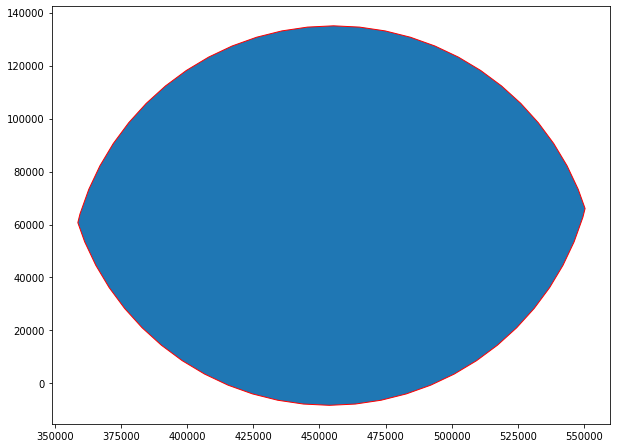

In [44]:
#get intersection of kampala and luwero
result = gpd.overlay(kampala_buffer, luwero_buffer, how='intersection')
result.plot(figsize=(10, 10), edgecolor='red')

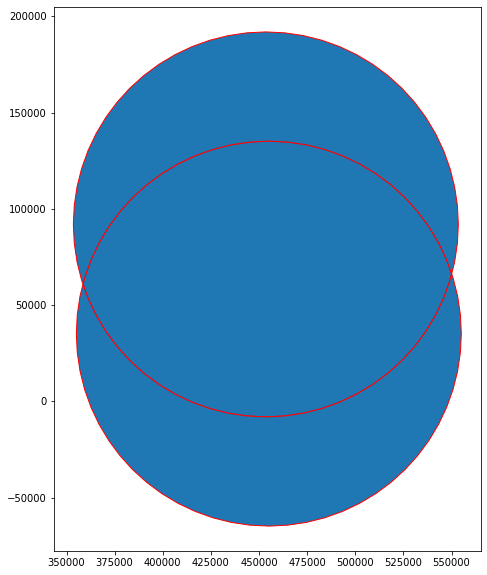

In [45]:
#get union of kampala and luwero
result = gpd.overlay(kampala_buffer, luwero_buffer, how='union')
result.plot(figsize=(10, 10), edgecolor='red')

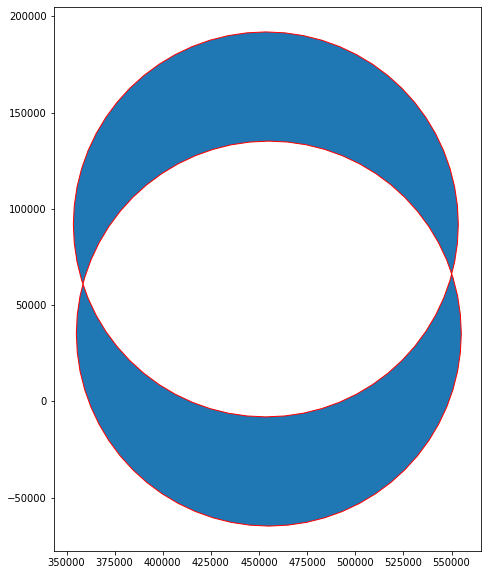

In [46]:
#get symmetric difference of kampala and luwero
result = gpd.overlay(kampala_buffer, luwero_buffer, how='symmetric_difference')
result.plot(figsize=(10, 10), edgecolor='red')

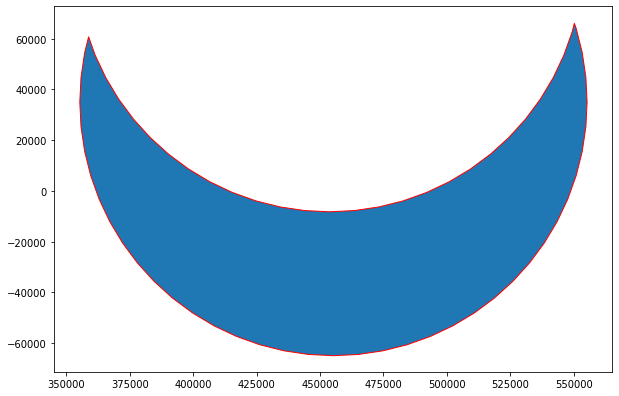

In [47]:
#get difference of kampala and luwero (order matters)
result = gpd.overlay(kampala_buffer, luwero_buffer, how='difference')
result.plot(figsize=(10, 10), edgecolor='red')

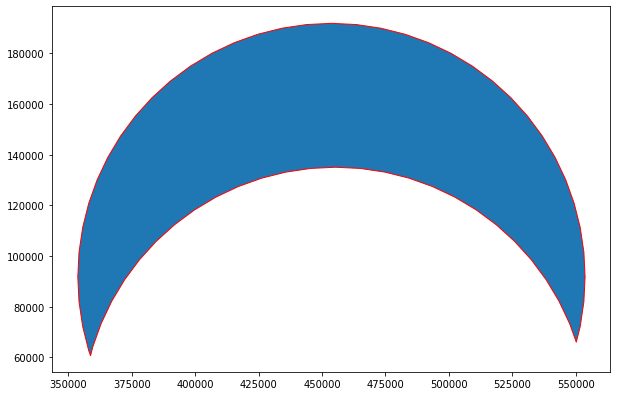

In [48]:
#get difference of luwero and kampala (order matters)
result = gpd.overlay(luwero_buffer, kampala_buffer, how='difference')
result.plot(figsize=(10, 10), edgecolor='red')

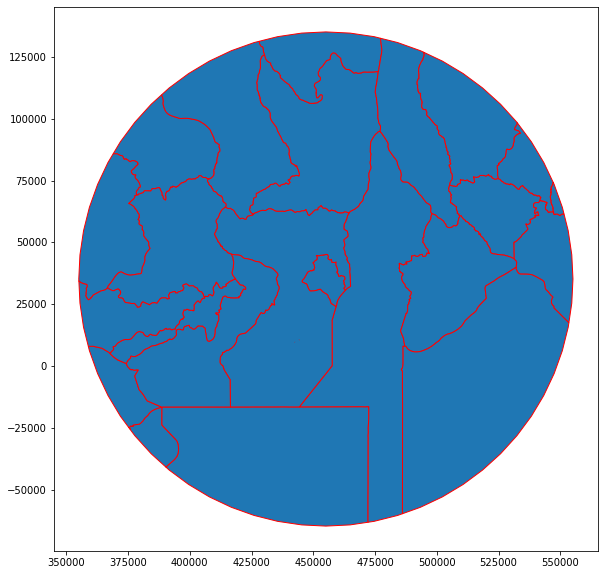

In [49]:
#clip uganda_all by kampala_buffer #fairly slow, heavy on resources
result = gpd.clip(uganda_all, kampala_buffer)
#good to retain only geometry column since the attribute columns dont make sense after disolving
result = result.geometry
result.plot(figsize=(10, 10), edgecolor='red')

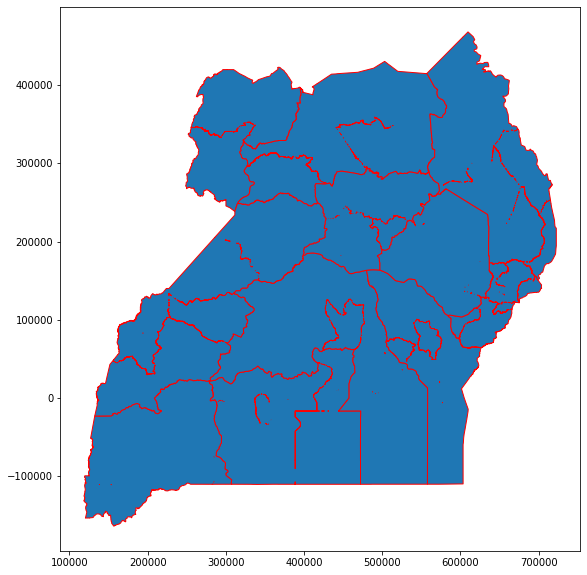

In [50]:
#dissolve uganda_all by SUBREGION #fairly slow, heavy on resources
result = uganda_all.dissolve(by='SUBREGION')
#good to retain only geometry column since the attribute columns dont make sense after disolving
result = result.geometry
result.plot(figsize=(10, 10), edgecolor='red')